In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline

text_column = 'reviews'
data = pd.read_csv('playlist_with_reviews.csv',index_col=1)
data = data[[text_column,'love']]
data[text_column] = data[text_column].apply(lambda x: unicode(x, errors='replace'))
print data.ix['Feet and Bones'].reviews[:250]

[Though Minnesota quintet Trampled By Turtles has long been tagged as a progressive bluegrass act, their lonesome, minimalist aesthetic pushes them head-on into folk territory. Nowhere has that been more apparent than on Wild Animals , the band's fol


In [38]:
data.head()

,reviews,love
track_name,,
Good Vibrations - 2001 - Remaster,[The Beach Boys' self-image has always been ou...,1
Feet and Bones,[Though Minnesota quintet Trampled By Turtles ...,1
Lonesome Dreams,[I'm not someone who should be gushing over an...,1
Siberian Breaks,[The wait is over! Record Store Day 2014 is th...,1
Amen,[Cohen's second release since last September's...,1


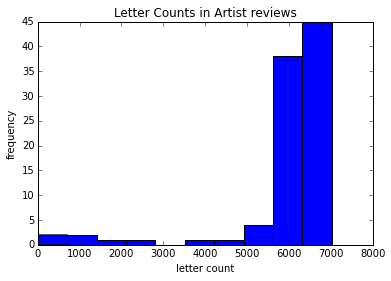

In [26]:
plt.hist(data[text_column].apply(lambda x: len(x)))
plt.title('Letter Counts in Artist %s'%text_column)
plt.ylabel('frequency')
plt.xlabel('letter count')
plt.show()

In [39]:
print len(data[data['love']==1])
print len(data[data['love']==0])

62
33


#Model
1. Preprocessing:
    * account for part of speech
2. Convert raw text to feature values
    *  TF-IDF
    *  POS tagging
    *  Sentiwordnet scores
    *  use `feature union` class to combine
3. Make pipeline with tf-idf and multinomialNB
    * fit on shufflesplit

##1. A Naive Baseline Model

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.cross_validation import ShuffleSplit

X = data[text_column]
Y = data['love']

def create_ngram_model(params=None):
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1,3),
                                   analyzer='word',
                                   binary=False)
    clf = MultinomialNB()
    pipeline =  Pipeline([('vect', tfidf_ngrams),
                          ('clf', clf)])
    if params:
        pipeline.set_params(**params)
    
    return pipeline
    

def plot_pr(auc_score, name, precision, recall, label=None):
    plt.clf()
    plt.figure(num=None, figsize=(5, 4))
    plt.grid(True)
    plt.fill_between(recall, precision, alpha=0.5)
    plt.plot(recall, precision, lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R curve (AUC=%0.2f) / %s' % (auc_score, label))

def _train_model(clf_factory, X, Y, pos_label=1, plot=True, name='NB ngram'):
    cv = ShuffleSplit(n=len(X), n_iter=10, 
                test_size=0.3, random_state=0)
    scores = []
    pr_scores = []
    precisions, recalls, thresholds = [], [], []
    
    for train, test in cv:
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]
        
        clf = clf_factory()
        clf.fit(X_train, Y_train)
        
        train_score = clf.score(X_train, Y_train)
        test_score = clf.score(X_test, Y_test)
        
        scores.append(test_score)
        proba = clf.predict_proba(X_test)
        
        precision, recall, pr_thresholds = \
                precision_recall_curve(Y_test, proba[:,pos_label], pos_label=pos_label)
        
        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)
        
    scores_to_sort = pr_scores
    median = np.argsort(scores_to_sort)[len(scores_to_sort)/2]
    
    print "mean scores: %.3f, std error: %.3f"%(np.mean(scores), np.std(scores))
    print "mean precision: %.3f, std error: %.3f"%(np.mean(pr_scores),np.std(pr_scores))
    print "best threshold: ", np.mean(thresholds[median])
    
    if plot:
        plot_pr(pr_scores[median], name, 
                    precisions[median],
                    recalls[median],
                    label=name)



mean scores: 0.666, std error: 0.066
mean precision: 0.778, std error: 0.086
best threshold:  0.855506224253


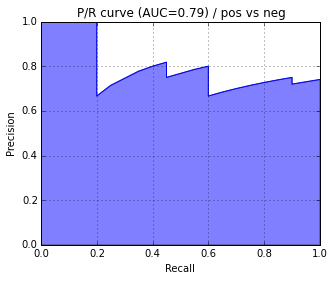

In [77]:
_train_model(create_ngram_model, X, Y, name='pos vs neg')

mean scores: 0.666, std error: 0.066
mean precision: 0.476, std error: 0.084
best threshold:  0.166733569503


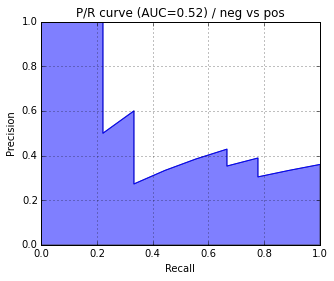

In [79]:
_train_model(create_ngram_model, X, Y, pos_label=0, name='neg vs pos')

# train_model(create_ngram_model, X, Y, pos_label=0, name='neg vs pos')

Note, I ran the following and it returned the same negative versus positive graph above, to deal with some of the confusion about labels.  `train_model(create_ngram_model, X, 1-Y, pos_label=1, name='test')`

##2. Tuning the Classifier
###I have to train the following classes for the model above
TfidfVectorizer:
* different settings for Ngrams
* min_df
* use_idf or smooth_idf in TF-IDF
* removing stop words
* whether to use log word counts
* track word counts or booleans

MultinomialNB:
* smoothing method by setting alpha
    * add-one or laplace smoothing: 1
    * Lidstone smoothing: 0.01, 0.05, 0.1, 0.5
    * No smoothing.

###GridSearchCV:
* takes estimator arg (Pipeline in this case and dict of parameters)
* interface: `<estimator>__<subestimator>__...__<param_name>: <list of values>`
* cv parameter
* score function is f1_score
* takes a long time because 1152 different parameter combinations trained over 10 folds each.

In [61]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score

def grid_search_model(clf_factory, X, Y):
    cv = ShuffleSplit(n=len(X),
            n_iter=10,
            test_size=0.3,
            random_state=0)
    
    param_grid = dict(vect__ngram_range=[(1,1),(1,2),(1,3)],
            vect__min_df=[1,2],
            vect__stop_words=[None, "english"],
            vect__smooth_idf=[False, True],
            vect__use_idf=[False, True],
            vect__sublinear_tf=[False, True],
            vect__binary=[False, True],
            clf__alpha=[0,0.01,0.05,0.1,0.5,1])
    
    grid_search = GridSearchCV(clf_factory(),
            param_grid=param_grid,
            cv=cv,
            score_func=f1_score,
            verbose=1)

    grid_search.fit(X,Y)
    return grid_search.best_estimator_

In [62]:
clf = grid_search_model(create_ngram_model, X, Y)
print clf

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:   58.9s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:  4.6min
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:  7.2min
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed: 12.2min
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed: 18.4min
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed: 25.5min
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed: 32.5min
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed: 41.2min
[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed: 50.8min
[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed: 62.5min
[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed: 76.2min
[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed: 144.8min
[Parallel(n_jobs=1)]: Done 9800 jobs       | elapsed: 163.5min
[Parallel(n_jobs=1)]: Done 11250 jobs       | elapsed: 640.0min


Fitting 10 folds for each of 1152 candidates, totalling 11520 fits
Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None,
        smooth_id...e_idf=True, vocabulary=None)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])


[Parallel(n_jobs=1)]: Done 11520 out of 11520 | elapsed: 647.0min finished


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.cross_validation import ShuffleSplit

X = data[text_column]
Y = data['love']

def create_ngram_model(params=None):
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1,3),
                                   analyzer='word',
                                   binary=False)
    clf = MultinomialNB()
    pipeline =  Pipeline([('vect', tfidf_ngrams),
                          ('clf', clf)])
    if params:
        pipeline.set_params(**params)
    
    return params
    

def plot_pr(auc_score, name, precision, recall, label=None):
    plt.clf()
    plt.figure(num=None, figsize=(5, 4))
    plt.grid(True)
    plt.fill_between(recall, precision, alpha=0.5)
    plt.plot(recall, precision, lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R curve (AUC=%0.2f) / %s' % (auc_score, label))

def train_model(clf, X, Y, pos_label=1, plot=True, name='NB ngram'):
    cv = ShuffleSplit(n=len(X), n_iter=10, 
                test_size=0.3)
    scores = []
    pr_scores = []
    precisions, recalls, thresholds = [], [], []
    
    for train, test in cv:
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]
        
        clf.fit(X_train, Y_train)
        
        train_score = clf.score(X_train, Y_train)
        test_score = clf.score(X_test, Y_test)
        
        scores.append(test_score)
        proba = clf.predict_proba(X_test)
        
        precision, recall, pr_thresholds = \
                precision_recall_curve(Y_test, proba[:,pos_label], pos_label=pos_label)
        
        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)
        
    scores_to_sort = pr_scores
    median = np.argsort(scores_to_sort)[len(scores_to_sort)/2]
    
    print "mean scores: %.3f, std error: %.3f"%(np.mean(scores), np.std(scores))
    print "mean precision: %.3f, std error: %.3f"%(np.mean(pr_scores),np.std(pr_scores))
    print "best threshold: ", np.mean(thresholds[median])
    
    if plot:
        plot_pr(pr_scores[median], name, 
                    precisions[median],
                    recalls[median],
                    label=name)


train_model(clf, X, Y, name='tuned pos vs. neg')

mean scores: 0.690, std error: 0.067
mean precision: 0.601, std error: 0.126
best threshold:  0.28504148104


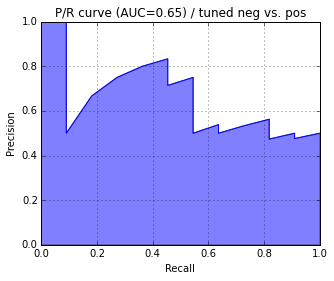

In [89]:
train_model(clf, X, 1-Y, pos_label=1, name='tuned neg vs. pos')

#3. Taking into Account SentWordNet and Part of Speech

in the following, if a word has multiple meanings in different contexts, the socres for those multiple contexts are combined.

In [22]:
import csv
import collections
import sys
sys.setdefaultencoding("utf-8")

def load_sent_word_net(swn_file='SentiWordNet_3.0.0_20130122.txt'):
    sent_scores = collections.defaultdict(list)
    with open(swn_file) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith("#"): continue
            if len(line) == 1: continue
            
            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS) == 0 or len(ID) == 0: continue
            
            for term in SynsetTerms.split(" "):
                #drop #number at end of every term
                term = term.replace("-"," ").replace("_"," ")
                key = '%s/%s'%(POS, term.split("#")[0])
                sent_scores[key].append((float(PosScore),float(NegScore)))
        for key, value in sent_scores.items():
            sent_scores[key] = np.mean(value, axis=0)
        
        return sent_scores
sent_word_net = load_sent_word_net()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB
import nltk
import re

class LinguisticVectorizer(BaseEstimator):
    def get_feature_names(self):
        return np.array(['sent_neut', 'sent_pos', 'sent_neg',
                         'nouns', 'adjectives', 'verbs', 'adverbs',
                         'allcaps', 'exclamation', 'question'])

    def fit(self, documents, y=None):
        return self
    
    def _get_sentiments(self, d):
        sent = tuple(nltk.word_tokenize(d))
        tagged = nltk.pos_tag(sent)

        pos_vals = []
        neg_vals = []

        nouns = 0.
        adjectives = 0.
        verbs = 0.
        adverbs = 0.

        for w, t in tagged:
            p, n = 0, 0
            sent_pos_type = None
            if t.startswith("NN"):
                sent_pos_type = "n"
                nouns += 1
            elif t.startswith("JJ"):
                sent_pos_type = "a"
                adjectives += 1
            elif t.startswith("VB"):
                sent_pos_type = "v"
                verbs += 1
            elif t.startswith("RB"):
                sent_pos_type = "r"
                adverbs += 1

            if sent_pos_type is not None:
                sent_word = "%s/%s" % (sent_pos_type, w)

                if sent_word in sent_word_net:
                    p, n = sent_word_net[sent_word]

            pos_vals.append(p)
            neg_vals.append(n)

        l = len(sent)
        avg_pos_val = np.mean(pos_vals)
        avg_neg_val = np.mean(neg_vals)

        return [1 - avg_pos_val - avg_neg_val, avg_pos_val, avg_neg_val,
                nouns / l, adjectives / l, verbs / l, adverbs / l]

    def transform(self, documents):
        obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs = np.array(
            [self._get_sentiments(d) for d in documents]).T

        allcaps = []
        exclamation = []
        question = []

        for d in documents:
            allcaps.append(
                np.sum([t.isupper() for t in d.split() if len(t) > 2]))

            exclamation.append(d.count("!"))
            question.append(d.count("?"))

        result = np.array(
            [obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs, allcaps,
             exclamation, question]).T

        return result

re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
}

def create_union_model(params=None):
    def preprocessor(doc):
        doc = doc.lower()

        for r, repl in re_repl.items():
            doc = re.sub(r, repl, doc)

        return doc.replace("-", " ").replace("_", " ")

    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor,
                                   analyzer="word",
                                   decode_error='ignore')
    ling_stats = LinguisticVectorizer()
    all_features = FeatureUnion(
        [('ling', ling_stats), ('tfidf', tfidf_ngrams)])
#     all_features = FeatureUnion([('tfidf', tfidf_ngrams)])
#     all_features = FeatureUnion([('ling', ling_stats)])
    clf = MultinomialNB()
    pipeline = Pipeline([('all', all_features), ('clf', clf)])

    if params:
        pipeline.set_params(**params)

    return pipeline

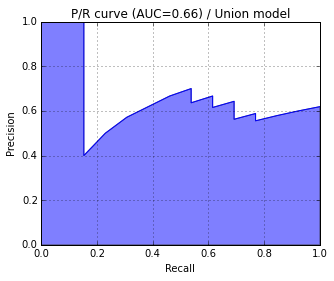

In [31]:
train_model(create_union_model(), X, Y, name='Union model')

This is worse than my first try, with a naive model and no paramter setting. Tuning this model would obviously help, but it took about an hour to do this one run, so tuning this model would absolutely take forever without parallel computing, which I don't know how to do yet.